In [27]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [28]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [29]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [30]:
%matplotlib inline

In [31]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous

X_motion_CoM = np.vstack((X_motion_CoM_acceleration, X_motion_CoM_continuous))
Y_motion_CoM = np.vstack((Y_motion_CoM_acceleration, Y_motion_CoM_continuous))
print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

(18169, 28)
(18169, 3)


In [32]:
X_motion_CoM[0, :]

array([0.10000000149, 0.0, 0.0, -0.000890185791332, -0.00484342625699,
       -0.0016179894701, -0.00407560999425, -0.00107515501585,
       -0.00510968513852, 106.788537736, 0.10975357348, 0.0264453367638,
       106.792137872, -0.219981122143, 0.0264500947938, 106.312148598,
       0.108510310608, 0.0264116215657, 106.309447442, -0.219160371546,
       0.0264162702676, False, True, True, False, 0.10000000149, 0.0, 0.0],
      dtype=object)

# Multivariate Linear Regression (Foot prediction)

In [33]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [34]:
# Entries where FL foot is swinging
idx_fl_rr_swinging = np.where(X_motion_CoM[:, 21] == 1)[0]
X_motion_CoM_FL_RR = X_motion_CoM[idx_fl_rr_swinging]
Y_motion_CoM_FL_RR = Y_motion_CoM[idx_fl_rr_swinging]

In [35]:
idx_fl_rr_swinging.shape

(9121,)

## Predict CoM -> x

In [36]:
X_motion_CoM_FL_RR[0, :]

array([0.10000000149, 0.0, 0.0, 0.0276850832543, 0.000496724746146,
       0.00284803431273, 0.000506401666187, 0.0011925380954,
       0.00615131733139, 106.789163975, 0.109400744015, 0.0264397917355,
       106.807136589, -0.227203049299, 0.0264199638448, 106.327427989,
       0.108357602103, 0.0264432688213, 106.309839416, -0.219508056488,
       0.0264249656973, True, False, False, True, 0.10000000149, 0.0, 0.0],
      dtype=object)

In [37]:
Y_motion_CoM_FL_RR[0, :]

array([0.0069339709574762765, 0.003976454186229522, 7.877599662749484e-05],
      dtype=object)

### Linear Regression

In [38]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, -3:], # Current motion command
               X_motion_CoM_FL_RR[:, 9:11], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 15:17], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 18:20])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True, random_state=100)

# Create the model
model_fl_com_x = LinearRegression()

# Fit the model
model_fl_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9495420264380412
RMSE:  0.009599830178680107
The lowest error is:  2.837706876517715e-06
The highest error is:  0.08658472015938433
The avg. error is:  0.005646428042104561


In [39]:
model_fl_com_x.coef_

array([[ 0.0391748 , -0.02654345, -0.00020698,  0.11910251,  0.03364747,
         0.00046641,  0.02275698, -0.06345089, -0.0512084 ,  0.06847888,
        -0.01518207,  0.10679173,  0.04363531, -0.11186685]])

In [40]:
model_fl_com_x.intercept_

array([-0.00423869])

In [41]:
input_ = np.array([[0.0,0.0,0.0,0.1,0.0,0.0,0.2399, 0.134, 0.2399, -0.134, -0.2399, 0.134, -0.2399, -0.134]])
input_ @ model_fl_com_x.coef_.T + model_fl_com_x.intercept_

array([[0.00564179]])

Text(0, 0.5, 'Predictions')

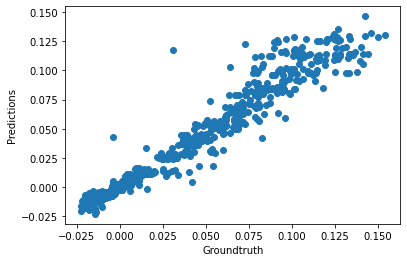

In [42]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [43]:
#%store model_fl_com_x

In [44]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [45]:
# Save model
#joblib.dump(model_fl_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_x.sav")

## Predict CoM -> y

### Linear Regression

In [46]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # motion command
               X_motion_CoM_FL_RR[:, -3:], # Current motion command
               X_motion_CoM_FL_RR[:, 9:11], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 15:17], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 18:20])) 

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_y = LinearRegression()

# Fit the model
model_fl_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9256261581870294
RMSE:  0.007809814745209343
The lowest error is:  9.9844967424087e-09
The highest error is:  0.12122836012735233
The avg. error is:  0.004849083400689529


In [47]:
model_fl_com_y.coef_

array([[-0.03531344,  0.00699435,  0.00035215,  0.03261313,  0.14943567,
        -0.00040065, -0.02418721, -0.00465943,  0.09854855,  0.00970225,
         0.03226934, -0.09730781, -0.10662044,  0.09227992]])

In [48]:
model_fl_com_y.intercept_

array([-0.0003114])

Text(0, 0.5, 'Predictions')

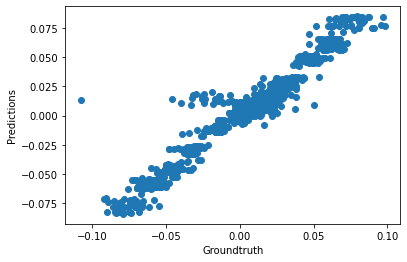

In [49]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [50]:
#%store model_fl_com_y

In [51]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [52]:
# Save model
#joblib.dump(model_fl_com_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_y.sav")

## Predict CoM -> Yaw

In [57]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # motion command
               X_motion_CoM_FL_RR[:, -3:], # Current motion command
               X_motion_CoM_FL_RR[:, 9:11], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 15:17], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 18:20])) 

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_theta = LinearRegression()

# Fit the model
model_fl_com_theta.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_theta.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9311078199550166
RMSE:  0.006317571602558421
The lowest error is:  2.0960042349839336e-07
The highest error is:  0.1335839245519615
The avg. error is:  0.0016593831642808267


In [58]:
model_fl_com_theta.coef_

array([[ 0.00272546,  0.0030142 ,  0.10701381, -0.00118914, -0.00275173,
         0.02766265, -0.007554  , -0.00654397,  0.01315691, -0.00421638,
        -0.00679908, -0.00151816,  0.00119611,  0.01227973]])

In [59]:
model_fl_com_theta.intercept_

array([-6.37289998e-05])

Text(0, 0.5, 'Predictions')

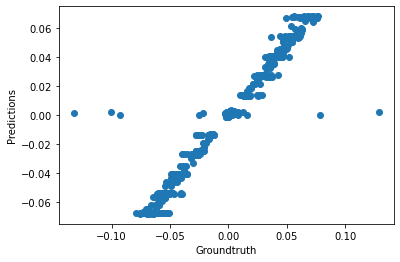

In [60]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")